# Question 01

## Initialize

Install libs

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install -U ydata-profiling[notebook]
    !pip install jupyter-contrib-nbextensions
    !pip install pycaret[full]

Mount Drive

In [2]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Import Libs

In [ ]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

Setting Params

In [5]:
if 'google.colab' in sys.modules:
    FOLDER_PATH = '/content/drive/MyDrive/data_files_challenge/'
else:
    FOLDER_PATH = './data/'

In [5]:
plt.rcParams['font.family'] = 'DejaVu Sans'

## Load Data

In [ ]:
aug_forecast_df = pd.read_parquet(f'{FOLDER_PATH}august_total_sales.parquet')
hist_orders_df = pd.concat([pd.read_parquet(f'{FOLDER_PATH}historical_orders_part_{i}.parquet') for i in range(1,5)])
aug_predict_df = pd.read_parquet(f'{FOLDER_PATH}august_with_missing_order_days.parquet')

## EDA

### Forecast Dataset

In [7]:
profile = ProfileReport(aug_forecast_df, title="Data Profile", explorative=True, minimal=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Historical Dataset

In [8]:
profile = ProfileReport(hist_orders_df, title="Data Profile", explorative=True, minimal=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Predict Dataset

In [9]:
profile = ProfileReport(aug_predict_df, title="Data Profile", explorative=True, minimal=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Main Findings

**Forecast Dataset**
* Noticed **negative** values for amount column (0.5%) - We shouldn't expect negative values for amount
* Noticed **zero** values for amount column (0.3%) - We shouldn't expect zero values for amount
* Noticed **huge** values - We should consider as an outlier

**Actions**
* Remove negative values
* Remove zero values
* Remove outliers using IQR (Interquartile Range)



---

**Historical Dataset**
* Noticed **negative** values for amount column (1.1%%) - We shouldn't expect negative values for amount
* Noticed **zero** values for amount column (2.2%) - We shouldn't expect zero values for amount
* Noticed **huge** values - We should consider as an outlier

**Actions**
* Remove negative values
* Remove zero values
* Remove outliers using IQR (Interquartile Range)



---

**Predict Dataset**
* Noticed **negative** values for amount column (3.0%) - We shouldn't expect negative values for amount
* Noticed **zero** values for amount column (0.1%) - We shouldn't expect zero values for amount
* Noticed **huge** values - We should consider as an outlier

**Actions**
* Remove negative values
* Remove zero values
* Remove outliers using IQR (Interquartile Range)



## Preprocessing

### Data Cleaning

Setting Helper Function

In [10]:
def remove_zeros_negative_outliers_iqr(df, column):
    prev_len = len(df)
    print('Previous Lower Bound: ', df[column].min())
    print('Previous Upper Bound: ', df[column].max())

    # Remove zeros and negatives
    df = df[df[column] > 0]

    min_threshold = df[column].quantile(0.5)
    # Check for very small values (e.g., values less than 1)
    min_threshold = 1 #df[column].quantile(0.01)
    df = df[df[column] >= min_threshold]

    # Perform IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = min_threshold #Q1 - 1.5 * IQR
    upper_bound = Q3 + 2.5 * IQR

    print('New Lower Bound: ', lower_bound)
    print('New Upper Bound: ', upper_bound)

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Log data loss
    data_loss = 1 - len(df) / prev_len

    print(f'Data Loss: {data_loss:.2%}')

    return df.reset_index(drop=True)

#### Forecast Dataset

In [11]:
aug_forecast_df_cleaned = remove_zeros_negative_outliers_iqr(aug_forecast_df, 'total_transaction_amount_august')

Previous Lower Bound:  -9108.0
Previous Upper Bound:  2638720.17
New Lower Bound:  1
New Upper Bound:  14636.2975
Data Loss: 8.39%


In [12]:
profile = ProfileReport(aug_forecast_df_cleaned, title="Data Profile", explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Historical Dataset

In [13]:
hist_orders_df_cleaned = remove_zeros_negative_outliers_iqr(hist_orders_df, 'transaction_amount')

Previous Lower Bound:  -607.5
Previous Upper Bound:  418578.92
New Lower Bound:  1
New Upper Bound:  623.0450000000001
Data Loss: 10.80%


In [14]:
profile = ProfileReport(hist_orders_df_cleaned, title="Data Profile", explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Predict Dataset

In [15]:
aug_predict_df_cleaned = remove_zeros_negative_outliers_iqr(aug_predict_df, 'transaction_amount')

Previous Lower Bound:  -99.0
Previous Upper Bound:  171325.44
New Lower Bound:  1
New Upper Bound:  643.2249999999999
Data Loss: 14.40%


In [16]:
profile = ProfileReport(aug_predict_df_cleaned, title="Data Profile", explorative=True, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Feature Engineering

### Helper Functions

In [17]:
def get_order_days(data):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = data.copy()

    # Convert the 'order_date' column to datetime format for proper date handling
    df['order_date'] = pd.to_datetime(df['order_date'])

    # Group the DataFrame by 'account_id' and 'order_date' and sum the 'transaction_amount' for each group
    df = df.groupby(['account_id', 'order_date'])['transaction_amount'].sum().reset_index().rename(columns={'transaction_amount': 'daily_amount'})

    # Sort the DataFrame by 'account_id' and 'order_date' to ensure correct order for cumulative calculations
    df = df.sort_values(['account_id', 'order_date'])

    # Create a new column 'year_month' to represent the month and year of each order
    df['year_month'] = df['order_date'].dt.to_period('M')

    # Drop duplicate entries based on account_id, year_month, and order_date to ensure unique days
    df_unique_days = df.drop_duplicates(subset=['account_id', 'year_month', 'order_date'])

    # Calculate the order days as a cumulative count of orders for each account and month
    df_unique_days['order_days'] = df_unique_days.groupby(['account_id', 'year_month']).cumcount() + 1

    # Merge the calculated order_days back into the original DataFrame based on account_id and order_date
    df = df.merge(df_unique_days[['account_id', 'order_date', 'order_days']], on=['account_id', 'order_date'], how='left')

    return df

In [18]:
def add_missing_first_day(data):
    df = data.copy()

    # Convert 'order_date' to datetime
    df['order_date'] = pd.to_datetime(df['order_date'])
    
    # Create 'year_month' column
    df['year_month'] = df['order_date'].dt.to_period('M')
    
    # Create a DataFrame with all first days of each month for each account_id
    first_days = df.groupby(['account_id', 'year_month']).agg({'order_date': 'min'}).reset_index()
    first_days['first_day_of_month'] = first_days['year_month'].dt.to_timestamp()
    
    # Merge to find missing first days
    merged = pd.merge(first_days, df, how='left', left_on=['account_id', 'first_day_of_month'], right_on=['account_id', 'order_date'], indicator=True)
    
    # Filter rows where the first day is missing
    missing_first_days = merged[merged['_merge'] == 'left_only'][['account_id', 'first_day_of_month', 'year_month_x']]
    missing_first_days = missing_first_days.rename(columns={'first_day_of_month': 'order_date', 'year_month_x': 'year_month'})
    missing_first_days['daily_amount'] = 0
    missing_first_days['order_days'] = 0
    
    # Concatenate the original DataFrame with the missing first days
    df = pd.concat([df, missing_first_days[['account_id', 'order_date', 'daily_amount', 'year_month', 'order_days']]])
    
    # Sort and reset index
    df = df.sort_values(by=['account_id', 'order_date']).reset_index(drop=True)
    
    return df

In [19]:
def set_target(data):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = data.copy()

    # Group by account_id and year_month to calculate the maximum order_days for each month
    max_orders = df.groupby(['account_id', 'year_month'])['order_days'].max().reset_index()

    # Rename the columns for clarity
    max_orders.columns = ['account_id', 'year_month', 'max_order_days']

    # Merge the maximum order_days back into the original DataFrame
    df = df.merge(max_orders, on=['account_id', 'year_month'], how='left')

    # Calculate the remaining orders by subtracting order_days from max_order_days
    df['remaining_orders'] = df['max_order_days'] - df['order_days']

    # Drop max order days auxiliar column
    df = df.drop(columns=['max_order_days'])

    return df

In [20]:
def get_order_days_features(data):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = data.copy()

    # Group by account_id and year_month to calculate the maximum order_days for each month
    max_order_days_per_month = df.groupby(['account_id', 'year_month'])['order_days'].max().reset_index()

    # Rename the 'order_days' column to 'max_order_days' for clarity
    max_order_days_per_month = max_order_days_per_month.rename(columns={'order_days': 'max_order_days'})

    # Set the index to account_id and year_month for easier calculations
    max_order_days_per_month = max_order_days_per_month.set_index(['account_id', 'year_month'])

    # Calculate the maximum order_days from the previous month
    max_order_days_per_month['order_days_last_month'] = max_order_days_per_month['max_order_days'].shift(1)

    # Calculate the cumulative average of max_order_days up to the previous month
    max_order_days_per_month['order_days_avg'] = max_order_days_per_month['max_order_days'].shift(1).expanding().mean()

    # Calculate the cumulative standard deviation of max_order_days up to the previous month
    max_order_days_per_month['order_days_std'] = max_order_days_per_month['max_order_days'].shift(1).expanding().std()

    # Reset the index to return to the original DataFrame structure
    max_order_days_per_month = max_order_days_per_month.reset_index()

    # Merge the calculated features back into the original DataFrame
    df = df.merge(max_order_days_per_month, on=['account_id', 'year_month'], how='left')

    # Drop max order days auxiliar column
    df = df.drop(columns=['max_order_days'])

    return df

In [21]:
def get_transaction_amount_features(data):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = data.copy()

    # Grouping by account_id and year_month to calculate totals
    transaction_amount_per_month = df.groupby(['account_id', 'year_month'])['daily_amount'].sum().reset_index()
    transaction_amount_per_month = transaction_amount_per_month.rename(columns={'daily_amount': 'total_transaction_amount'})

    # Setting the index for easier calculations
    transaction_amount_per_month = transaction_amount_per_month.set_index(['account_id', 'year_month'])

    # Amount spent current month (ASSUMPTION: We want to emulate the forecast same was as the august forecast dataset)
    transaction_amount_per_month['amount_forecasted'] = transaction_amount_per_month['total_transaction_amount']

    # Amount spent in the previous month
    transaction_amount_per_month['amount_last_month'] = transaction_amount_per_month['total_transaction_amount'].shift(1)

    # Average / Std of spending per transaction
    transaction_amount_per_month['avg_amount_per_transaction'] = df.groupby(['account_id'])['daily_amount'].mean().reindex(transaction_amount_per_month.index, level=0)
    transaction_amount_per_month['std_amount_per_transaction'] = df.groupby(['account_id'])['daily_amount'].std().reindex(transaction_amount_per_month.index, level=0)

    # Average / Std of spending per month (cumulative)
    transaction_amount_per_month['avg_amount_per_month'] = transaction_amount_per_month['total_transaction_amount'].expanding().mean()
    transaction_amount_per_month['std_amount_per_month'] = transaction_amount_per_month['total_transaction_amount'].expanding().std()

    # Cumulative within the month
    df['cumulative_monthly_transaction_amount'] = df.groupby(['account_id', 'year_month'])['daily_amount'].cumsum()

    # Resetting the index to return to the original format
    transaction_amount_per_month = transaction_amount_per_month.reset_index()

    # Merging with the original DataFrame
    df = df.merge(transaction_amount_per_month, on=['account_id', 'year_month'], how='left')

    df.drop(columns=['total_transaction_amount'], inplace=True)

    return df.fillna(0)

In [22]:
def get_transaction_date_features(data):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = data.copy()

    # Convert the 'order_date' column to datetime format if it's not already
    df['order_date'] = pd.to_datetime(df['order_date'])

    # Extract features from the 'order_date' column
    df['day_of_week'] = df['order_date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    df['month'] = df['order_date'].dt.month  # Month of the transaction
    df['day_of_month'] = df['order_date'].dt.day  # Day of the month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Indicator if the day is a weekend (Saturday=5, Sunday=6)

    # Return the DataFrame with the new features
    return df


In [23]:
def preprocessing_data(data):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = data.copy()

    # 1. Calculate the order days for each transaction and add the 'order_days' column to the DataFrame
    df = get_order_days(df)

    # 2. Add missing first days of the month with zero transactions
    df = add_missing_first_day(df)

    # 3. Set the target variable based on the maximum order days and calculate remaining orders
    df = set_target(df)

    # 4. Extract features related to order days, such as last month's order days, average, and standard deviation
    df = get_order_days_features(df)

    # 5. Extract features related to transaction amounts, such as last month's spending, average per transaction, and cumulative transaction amounts
    df = get_transaction_amount_features(df)

    # 6. Extract date-related features from the transaction date, including day of the week, month, year, day of the month, and weekend indicator
    df = get_transaction_date_features(df)

    return df

### Historical Dataset

In [24]:
hist_orders_df_preprocessed = preprocessing_data(hist_orders_df_cleaned)

In [25]:
hist_orders_df_preprocessed.head(20)

account_id order_date  daily_amount year_month  order_days  \
0   BR_00000343803 2021-01-01          0.00    2021-01           0   
1   BR_00000343803 2021-01-07        252.88    2021-01           1   
2   BR_00000343803 2021-01-14         49.52    2021-01           2   
3   BR_00000343803 2021-01-21        173.96    2021-01           3   
4   BR_00000343803 2021-01-30        338.56    2021-01           4   
5   BR_00000343803 2021-02-01          0.00    2021-02           0   
6   BR_00000343803 2021-02-11        111.20    2021-02           1   
7   BR_00000343803 2021-02-18        373.56    2021-02           2   
8   BR_00000343803 2021-03-01          0.00    2021-03           0   
9   BR_00000343803 2021-03-04        444.24    2021-03           1   
10  BR_00000343803 2021-03-20        108.72    2021-03           2   
11  BR_00000343803 2021-03-25        108.72    2021-03           3   
12  BR_00000343803 2021-04-01          0.00    2021-04           0   
13  BR_00000343803 2021-04-15        575.08    2021-04           1   
14  BR_00000343803 2021-05-01          0.00    2021-05           0   
15  BR_00000343803 2021-05-06        271.64    2021-05           1   
16  BR_00000343803 2021-05-20        285.64    2021-05           2   
17  BR_00000343803 2021-05-29        301.84    2021-05           3   
18  BR_00000343803 2021-06-01          0.00    2021-06           0   
19  BR_00000343803 2021-06-12        222.32    2021-06           1   

    remaining_orders  order_days_last_month  order_days_avg  order_days_std  \
0                  4                    0.0             0.0        0.000000   
1                  3                    0.0             0.0        0.000000   
2                  2                    0.0             0.0        0.000000   
3                  1                    0.0             0.0        0.000000   
4                  0                    0.0             0.0        0.000000   
5                  2                    4.0             4.0        0.000000   
6                  1                    4.0             4.0        0.000000   
7                  0                    4.0             4.0        0.000000   
8                  3                    2.0             3.0        1.414214   
9                  2                    2.0             3.0        1.414214   
10                 1                    2.0             3.0        1.414214   
11                 0                    2.0             3.0        1.414214   
12                 1                    3.0             3.0        1.000000   
13                 0                    3.0             3.0        1.000000   
14                 3                    1.0             2.5        1.290994   
15                 2                    1.0             2.5        1.290994   
16                 1                    1.0             2.5        1.290994   
17                 0                    1.0             2.5        1.290994   
18                 2                    3.0             2.6        1.140175   
19                 1                    3.0             2.6        1.140175   

    cumulative_monthly_transaction_amount  amount_forecasted  \
0                                    0.00             814.92   
1                                  252.88             814.92   
2                                  302.40             814.92   
3                                  476.36             814.92   
4                                  814.92             814.92   
5                                    0.00             484.76   
6                                  111.20             484.76   
7                                  484.76             484.76   
8                                    0.00             661.68   
9                                  444.24             661.68   
10                                 552.96             661.68   
11                                 661.68             661.68   
12                                   0.00    

## Feature Selection

**Approach:**
* Using the Random Feature technique to select the best features. 
* This technique involves adding a random feature to the dataset, training a Random Forest model, and then filtering out all features that have a feature importance greater than that of the random feature. 
* This helps in identifying and retaining only the most significant features for the model.

Sampling data, choosing 1 random month of data

In [26]:
sampled_months = np.random.choice(hist_orders_df_preprocessed['year_month'].unique(), size=1, replace=False)
sampled_df = hist_orders_df_preprocessed[hist_orders_df_preprocessed['year_month'].isin(sampled_months)].dropna()#.head(10000)

Adding random feature

In [27]:
sampled_df['random_feature'] = np.random.rand(len(sampled_df))

Training Random Forest Model

In [28]:
numeric_features = sampled_df.drop(columns=['account_id', 'year_month', 'remaining_orders', 'order_date']).columns.tolist()

regression_setup = setup(
    data=sampled_df[numeric_features + ['account_id']],
    target=sampled_df['remaining_orders'],
    fold_strategy='timeseries',
    fold=3,
    session_id=42,
    numeric_features=numeric_features,
    fold_groups='account_id',
    ignore_features=['account_id'],
    train_size=0.8,
    data_split_shuffle=False,
    normalize = True,
    normalize_method = 'minmax'
)

rf_model = create_model('rf')

Selecting features

In [29]:
feature_importances = pd.DataFrame({'importance': rf_model.feature_importances_}, index=numeric_features).sort_values(by='importance', ascending=False)
random_feature_score = feature_importances.loc['random_feature', 'importance']
selected_features = feature_importances[feature_importances['importance'] > random_feature_score].index.tolist()

selected_features

['day_of_month',
 'order_days_last_month',
 'amount_forecasted',
 'cumulative_monthly_transaction_amount',
 'avg_amount_per_transaction',
 'std_amount_per_transaction',
 'daily_amount',
 'amount_last_month']

## Model Development

### "Standard" Models

* Reduce the training dataset to only 3 months to minimize computational effort.
* Use data from July 2022 as the validation dataset.

In [ ]:
df_train = hist_orders_df_preprocessed[(hist_orders_df_preprocessed['order_date'] >= '2022-04-01') &
                                      (hist_orders_df_preprocessed['order_date'] < '2022-07-01')].dropna()

df_val = hist_orders_df_preprocessed[(hist_orders_df_preprocessed['order_date'] >= '2022-07-01') &
                                      (hist_orders_df_preprocessed['order_date'] < '2022-08-01')].dropna()

Using PyCaret to optmize model training and selection

**Assumptions:**
* The dataset is considered a Time-Series
* Using time-series data split to avoid data leakage (split is not shuffled)
* Using cross validation

In [ ]:
regression_setup = setup(
    data=df_train[selected_features + ['account_id']],
    target=df_train['remaining_orders'],
    fold_strategy='timeseries',
    fold=3,
    session_id=42,
    numeric_features=selected_features,
    fold_groups='account_id',
    train_size=0.8,
    data_split_shuffle=False,
    ignore_features=['account_id'],
    normalize = True,
    normalize_method = 'minmax'
)

# Comparar modelos e exibir os resultados
resultados = compare_models()

# Criar o modelo final
modelo_final = create_model(resultados)

# Avaliar o modelo
evaluate_model(modelo_final)

Initiated  . . . . . . . . . . . . . . . . . .                 04:18:12
Status     . . . . . . . . . . . . . . . . . .          Fitting 3 Folds
Estimator  . . . . . . . . . . . . . . . . . .  Random Forest Regressor

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

Checking Performance on Validation Dataset

In [ ]:
y_true = df_val['remaining_orders']
y_pred = predict_model(modelo_final, data=df_val[selected_features + ['account_id']])['prediction_label'].round()

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")

R-squared: 0.8178811974795602
RMSE: 0.8010174644518652


### Neural Network

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

* Utilize almost all available data for training, as Neural Networks perform better with larger datasets.
* Use data from July 2022 as the validation dataset.

In [ ]:
df_train = hist_orders_df_preprocessed[(hist_orders_df_preprocessed['order_date'] < '2022-07-01')].dropna()

df_val = hist_orders_df_preprocessed[(hist_orders_df_preprocessed['order_date'] >= '2022-07-01') &
                                      (hist_orders_df_preprocessed['order_date'] < '2022-08-01')].dropna()

Using PyCaret, but only for train/test split

In [ ]:
regression_setup = setup(
    data=df_train[selected_features + ['account_id']],
    target=df_train['remaining_orders'],
    fold_strategy='timeseries',
    fold=3,
    session_id=42,
    numeric_features=selected_features,
    fold_groups='account_id',
    train_size=0.8,
    data_split_shuffle=False,
    ignore_features=['account_id'],
    normalize = True,
    normalize_method = 'minmax'
)

In [ ]:
X_train = get_config('X_train')
y_train = get_config('y_train')

X_val = get_config('X_test')
y_val = get_config('y_test')

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

#### Model Building and Training

In [ ]:
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.03),
    Dense(128, activation='relu'),
    Dropout(0.03),
    Dense(64, activation='relu'),
    Dropout(0.03),
    Dense(1, activation='linear') 
])


optimizer = Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights= True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-8
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=512,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
627/627 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 2.3023 - mae: 1.0169 - val_loss: 0.6559 - val_mae: 0.5536 - learning_rate: 0.0010
Epoch 2/200
627/627 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.7509 - mae: 0.5920 - val_loss: 0.5979 - val_mae: 0.5287 - learning_rate: 0.0010
Epoch 3/200
627/627 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6948 - mae: 0.5571 - val_loss: 0.5902 - val_mae: 0.5039 - learning_rate: 0.0010
Epoch 4/200
627/627 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6722 - mae: 0.5413 - val_loss: 0.5685 - val_mae: 0.4874 - learning_rate: 0.0010
Epoch 5/200
627/627 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6628 - mae: 0.5333 - val_loss: 0.5713 - val_mae: 0.4919 - learning_rate: 0.0010
Epoch 6/200
627/627 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.6520 - mae: 0.5270 - val_loss: 0.5674 - val_mae: 0.4761 - learning_rate: 0.0010
Epoch 7/200
627/627 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6492 - mae: 0.5234 - val_loss: 0.5607 - val_mae: 0.4895 - learning_

#### Model Evaluation

Validation dataset check

In [ ]:
X_val = df_val[selected_features]
X_val = scaler.transform(X_val)
y_val = df_val['remaining_orders']

# Previsões
y_pred = model.predict(X_val).flatten().round()

# Métricas
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")

3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
R-squared: 0.8427875335852539
RMSE: 0.7536149020609936


Training History

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

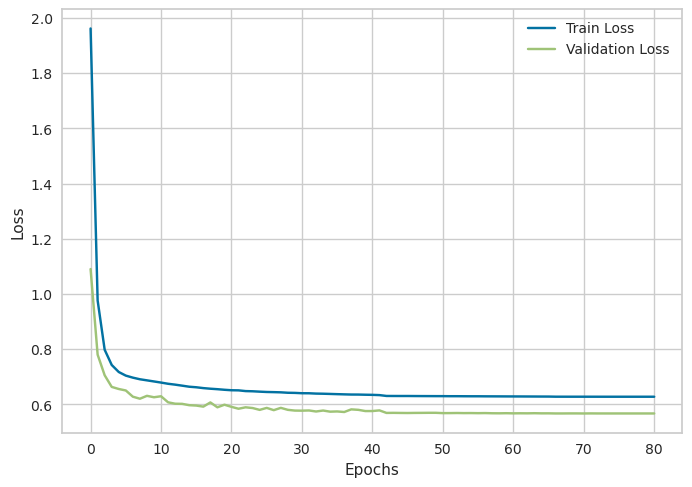

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Inference

### Preprocessing Data

#### Forecast Dataset

In [ ]:
# Gettin data removed during the cleaning process
removed_on_cleaning = aug_forecast_df[~aug_forecast_df.account_id.isin(aug_forecast_df_cleaned.account_id)][['account_id']].drop_duplicates().reset_index(drop=True)

# Fill missing values with the mean forecasted amount per account_id
removed_on_cleaning = removed_on_cleaning.merge(hist_orders_df_preprocessed.groupby('account_id')['amount_forecasted'].mean().reset_index(), on='account_id', how='left')

# Fill missing values with the overall mean forecasted amount
overall_forecast_mean = hist_orders_df_preprocessed['amount_forecasted'].mean()
removed_on_cleaning['amount_forecasted'] = removed_on_cleaning['amount_forecasted'].mask(removed_on_cleaning['amount_forecasted'].isnull(), overall_forecast_mean)

# Rename the columns to match the expected output
aug_forecast_df_cleaned = aug_forecast_df_cleaned.rename(columns={'total_transaction_amount_august': 'amount_forecasted'})

# Concatenate data
aug_forecast_df_preprocessed = pd.concat([aug_forecast_df_cleaned, removed_on_cleaning], ignore_index=True)

#### Predict Dataset

* When data is missing, considering Augst 1st and Transaction Amount = 0

In [ ]:
def preprocess_infer_data(raw_data, cleaned_data, hist_cleaned_data, start_date):
    raw_df = raw_data.copy()
    cleaned_df = cleaned_data.copy()
    start_date = pd.to_datetime(start_date)
    raw_df['order_date'] = pd.to_datetime(raw_df['order_date'])
    cleaned_df['order_date'] = pd.to_datetime(cleaned_df['order_date'])
    hist_cleaned_data['order_date'] = pd.to_datetime(hist_cleaned_data['order_date'])

    removed_on_cleaning = raw_df[~raw_df.account_id.isin(cleaned_df.account_id)][['account_id']].drop_duplicates().reset_index(drop=True)
    removed_on_cleaning['order_date'] = start_date
    removed_on_cleaning['transaction_amount'] = 0

    cleaned_df['order_date'] = cleaned_df['order_date'].mask(cleaned_df['order_date'].isnull(), start_date)
    cleaned_df['transaction_amount'] = cleaned_df['transaction_amount'].mask(cleaned_df['transaction_amount'].isnull(), 0)

    combined_df = pd.concat([cleaned_df, removed_on_cleaning, hist_cleaned_data[hist_cleaned_data.order_date < start_date]], ignore_index=True)
    combined_df.order_date = pd.to_datetime(combined_df.order_date)

    return combined_df

In [ ]:
aug_predict_df_combined = preprocess_infer_data(aug_predict_df, aug_predict_df_cleaned, hist_orders_df_preprocessed, '2022-08-01')

Generating features

In [ ]:
aug_predict_df_preprocessed = preprocessing_data(aug_predict_df_combined)
aug_predict_df_preprocessed = aug_predict_df_preprocessed[aug_predict_df_preprocessed['order_date'] >= '2022-08-01']

Getting Forcasted Amount for August

In [ ]:
aug_predict_df_preprocessed = aug_predict_df_preprocessed.drop(columns=['amount_forecasted'])
aug_predict_df_preprocessed = aug_predict_df_preprocessed.merge(aug_forecast_df_preprocessed, on='account_id', how='left')

#### Running Inference

In [ ]:
aug_predict_df_preprocessed['prediction'] = model.predict(scaler.transform(aug_predict_df_preprocessed[selected_features])).flatten().round()

2228/2228 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Adjusting final dataframe

In [ ]:
aug_predict_df_final = aug_predict_df_preprocessed.groupby('account_id')['order_date'].max().reset_index()
aug_predict_df_final = aug_predict_df_final.merge(aug_predict_df_preprocessed[['account_id', 'order_date', 'prediction']], on=['account_id', 'order_date'], how='left')
aug_predict_df_final = aug_predict_df_final[['account_id', 'prediction']]
aug_predict_df_final.prediction = aug_predict_df_final.prediction.astype(int)

Saving csv

In [ ]:
aug_predict_df_final.to_csv('./order_days_prediction.csv', index=False)

# Question 02

In [ ]:
import seaborn as sns
from scipy.stats import poisson
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Clustering Analysis

Analysis on the dataset to identify distinct groups of accounts based on their transaction behavior. We will use the KMeans algorithm for clustering and visualize the results.

#### Steps:
1. **Data Preparation**: Prepare the dataset for clustering by selecting relevant features and scaling the data.
2. **Clustering**: Apply the KMeans algorithm to cluster the data.
3. **Visualization**: Visualize the clusters to understand the distribution and characteristics of each cluster.

In [ ]:
features = hist_orders_df_preprocessed.groupby('account_id')[selected_features].mean().reset_index()

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(features[selected_features])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
features['cluster'] = kmeans.fit_predict(X)

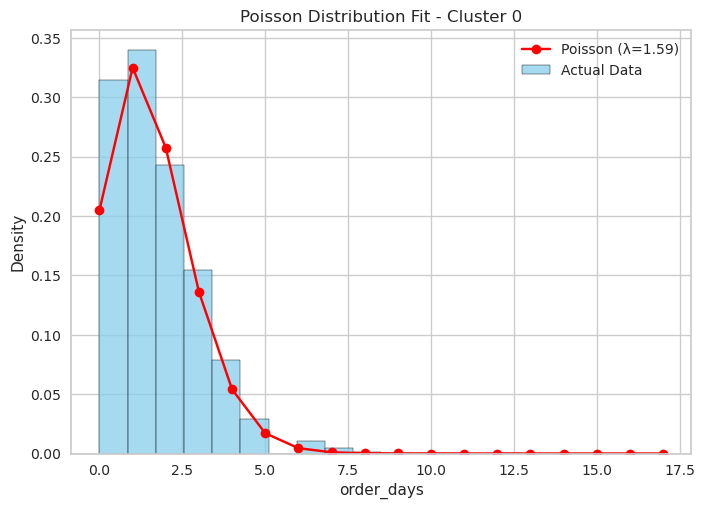

Poisson λ: 1.585725516354194
Probability of more than 4 order days (Poisson): 0.0229
Mean time between orders: 0.63 days


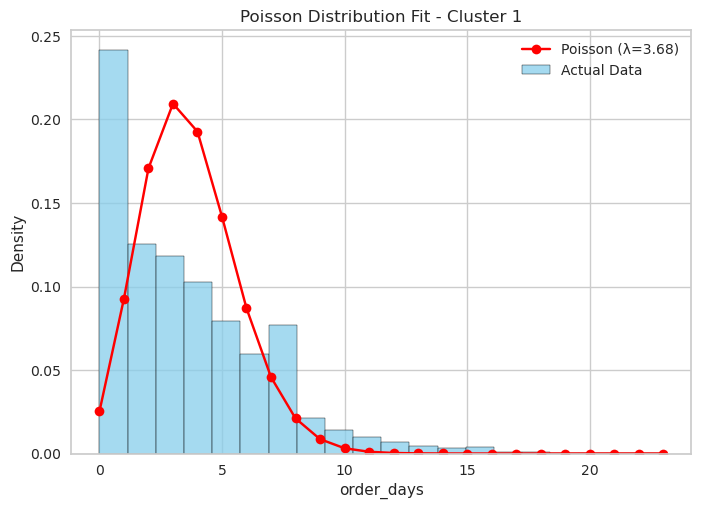

Poisson λ: 3.680146570061154
Probability of more than 4 order days (Poisson): 0.3090
Mean time between orders: 0.27 days


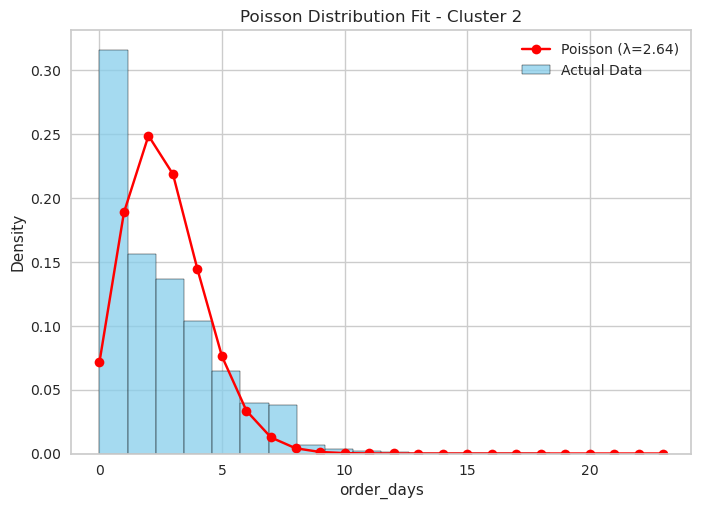

Poisson λ: 2.6366265938975015
Probability of more than 4 order days (Poisson): 0.1278
Mean time between orders: 0.38 days


In [ ]:
for i in range(3): 
    cluster_data = hist_orders_df_preprocessed[hist_orders_df_preprocessed['account_id'].isin(
        features[features['cluster'] == i]['account_id']
    )]
    order_days = cluster_data['order_days']

    # 2a: Determine distribution
    mean_orders = order_days.mean()
    var_orders = order_days.var()

    sns.histplot(order_days, kde=False, bins=20, color="skyblue", stat="density", label="Actual Data")
    x = np.arange(0, order_days.max() + 1)
    plt.plot(x, poisson.pmf(x, mu=mean_orders), 'o-', label=f"Poisson (λ={mean_orders:.2f})", color="red")
    plt.title(f"Poisson Distribution Fit - Cluster {i}")
    plt.legend()
    plt.show()

    # 2b: Estimate parameters
    lambda_poisson = mean_orders
    print(f"Poisson λ: {lambda_poisson}")

    # 2c: Probability of more than 4 days
    p_more_than_4 = 1 - poisson.cdf(4, mu=lambda_poisson)
    print(f"Probability of more than 4 order days (Poisson): {p_more_than_4:.4f}")

    # 2d: Estimate time between orders
    mean_time_between_orders = 1 / lambda_poisson
    print(f"Mean time between orders: {mean_time_between_orders:.2f} days")